# Project 3

Is a Picture Worth a Thousand Words Completed by: Terril Gibson, Adriana Cruz, Brian Zhao, James Madsen & Peter Delgado

# Task A

In [2]:
# Core Libraries
import os
import sys
import csv
import time
import random
import re
import requests

# Data Manipulation & Visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning / NLP
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# NLP Tools
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Google Cloud Vision
#from google.cloud import vision

# Web Scraping
from selenium.webdriver import Chrome, ChromeOptions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
#from fake_useragent import UserAgent

# Jupyter Notebook Display
from IPython.display import display

spacy.cli.download("en_core_web_sm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 6.7 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
# Instagram has some advanced anti-scraping mechanisms. You will need to run this scraper repeatedly, as it can only scrape between 20 - 40 post at a time before it's flagged
# and the connection is terminated by Instagram. My account created exclusively for this purpose was flagged Instagram as a bot, and threated to permanently suspend the
# account. Luckily this flag was recieved after i finished the final scrape

def scrape_natgeo_posts_description(num_posts=3000, output_file="natgeo_descriptions.csv"):
    try:
        sys.path.insert(0, '/Users/terri/chromedriver-win64/chromedriver')  #Specify Chromedriver file path
        driver = Chrome() # Activate Chrome Driver

        driver.get("https://www.instagram.com/accounts/login/") #Selenium will go to the instagram website and give you 60 sec to log in
        print("Please log in manually within the next 60 seconds...")
        time.sleep(60)

        driver.get("https://www.instagram.com/natgeo/") #After 60 seconds, you should have logged in, and selenium will go to the natgeo page
        print("Loading NatGeo page...")

        # Scroll for 2 minutes - Instagram loads post dynamically, so you have to scroll first to generate enough post to actually scrape
        start_time = time.time()
        while (time.time() - start_time) < 1100:  # 120 seconds = 2 minutes
            driver.find_element(By.TAG_NAME, 'body').send_keys(Keys.END)
            time.sleep(random.uniform(2, 4))  # Add a short random delay between scrolls

        try:
            WebDriverWait(driver, 20).until(
                EC.presence_of_all_elements_located((By.CSS_SELECTOR, "div.x1lliihq.x1n2onr6.xh8yej3.x4gyw5p.x11i5rnm.x1ntc13c.x9i3mqj.x2pgyrj")) #This is how selenium finds the post
            )
        except Exception as wait_error:
            print(f"Error waiting for posts to load: {wait_error}")
            return

        post_links = []
        post_elements = driver.find_elements(By.CSS_SELECTOR, "div.x1lliihq.x1n2onr6.xh8yej3.x4gyw5p.x11i5rnm.x1ntc13c.x9i3mqj.x2pgyrj")
        for post_element in post_elements[:num_posts]: # for each post, it will find the post URL
            try:
                link_element = post_element.find_element(By.CSS_SELECTOR, "a._a6hd")
                post_links.append(link_element.get_attribute('href'))
            except Exception as link_error:
                print(f"Error finding link in post: {link_error}")
                continue

        existing_links = set()
        if os.path.exists(output_file): #Ensures the post URL is not already in the natgeo_description.csv
            with open(output_file, "r", newline="", encoding="utf-8") as csvfile:
                reader = csv.reader(csvfile)
                next(reader, None)
                for row in reader:
                    if row:
                        existing_links.add(row[0])

        post_descriptions = []
        new_data = []
        for link in post_links: #For each post URL, finds the assoicated likes, comments, and caption
            if link in existing_links: #Skips Post URL that already exist int he natgeo_description.csv
                print(f"Skipping existing link: {link}")
                continue

            try:
                driver.get(link)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "meta[name='description']"))
                )
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                description_meta = soup.find('meta', attrs={'name': 'description'})
                if description_meta:
                    description = description_meta['content']
                    post_descriptions.append(description)
                    new_data.append([link, description])
                else:
                    post_descriptions.append("Description not found")
                    new_data.append([link, "Description not found"])
            except Exception as description_error:
                print(f"Error getting description for {link}: {description_error}")
                post_descriptions.append("Error retrieving description")
                new_data.append([link, "Error retrieving description"])

            time.sleep(random.randint(3, 5)) #randomly waits between 3 - 5 seconds to attempt the next post scrape

        if new_data: #Writes new Post URL, # likes, # comments, and caption back to natgeo_descriptions.csv
            with open(output_file, "a", newline="", encoding="utf-8") as csvfile:
                writer = csv.writer(csvfile)
                for row in new_data:
                    writer.writerow(row)

        print(f"Scraped descriptions successfully saved to {output_file}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    finally:
        if 'driver' in locals():
            driver.quit()
            print("Browser session closed.")

In [13]:
#Realize the specific Image URL was still needed, so this code allows for the scraping of the instagram post for specifically the Image URL. The benefit of this code is
#that it does not need to be logged into instagram to perform, as if you have the direct link to the post already it circumvents the content block


def scrape_instagram_image_urls(input_file="natgeo_descriptions.csv", output_file="image_urls.csv"):
    try:
        sys.path.insert(0, '/Users/terri/chromedriver-win64/chromedriver')
        ua = UserAgent() # Initiate a random user agent so your browser can appear as anything from Safari to Firefox
        options = ChromeOptions()
        options.add_argument(f"user-agent={ua.random}")
        driver = Chrome(options=options)

        if not os.path.exists(input_file):
            print(f"Input file '{input_file}' not found.")
            return

        df = pd.read_csv(input_file)
        post_urls = df["Post URL"].tolist()

        existing_image_urls = set()
        if os.path.exists(output_file):
            with open(output_file, "r", newline="", encoding="utf-8") as csvfile:
                reader = csv.reader(csvfile)
                next(reader, None)
                for row in reader:
                    if row and len(row) > 1:
                        existing_image_urls.add(row[1])

        image_urls = []
        for post_url in post_urls: #Use Beautiful Soup to locate the exact Image URL
            try:
                driver.get(post_url)
                WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.CLASS_NAME, '_aagv'))
                )

                soup = BeautifulSoup(driver.page_source, 'html.parser')
                div_tag = soup.find('div', class_='_aagv')
                if div_tag:
                    img_tag = div_tag.find('img')
                    if img_tag and img_tag.has_attr('src'):
                        image_url = img_tag['src']
                        if image_url in existing_image_urls:
                            print(f"Skipping existing image URL: {image_url}")
                            continue
                        image_urls.append([post_url, image_url])
                    else:
                        image_urls.append([post_url, "Image URL not found"])
                else:
                    image_urls.append([post_url, "Div tag not found"])

            except Exception as e:
                print(f"Error processing {post_url}: {e}")
                image_urls.append([post_url, "Error retrieving image URL"])

            time.sleep(random.uniform(3,7)) # wait 3-7 seconds between scrape attempts

        with open(output_file, "a", newline="", encoding="utf-8") as csvfile: #write post url and image url to image_urls.csv
            writer = csv.writer(csvfile)
            if not os.path.exists(output_file) or os.stat(output_file).st_size == 0:
                writer.writerow(["Post URL", "Image URL"])
            writer.writerows(image_urls)

        print(f"Image URLs saved to {output_file}")

    except Exception as e:
        print(f"An unexpected error occurred: {e}")

    finally:
        if 'driver' in locals():
            driver.quit()
            print("Browser session closed.")

In [ ]:
# Scrape the Post URLs and grab the Image URLS
scrape_instagram_image_urls()

In [ ]:

# Load the CSV file
test = pd.read_csv("natgeo_descriptions.csv")

# Initialize lists to store extracted data
likes_list = []
comments_list = []
extracted_descriptions = []

# Iterate through all descriptions and apply regex
for description in test["Description"]:
    # Enhanced regex pattern to match likes, comments, and capture description
    match = re.search(
        r'([\d,]+K|[\d,]+)\s*likes,\s*([\d,]+K|[\d,]+)\s*comments\s*-\s*(.+)',
        description,
        re.DOTALL,
    )
    if match:
        likes, comments, full_description = match.groups()

        # Remove commas and convert "K" into numbers (e.g., "116K" becomes 116000)
        likes = likes.replace(',', '').replace('K', '000') if 'K' in likes else likes.replace(',', '')
        comments = comments.replace(',', '').replace('K', '000') if 'K' in comments else comments.replace(',', '')

        # Extract everything after the first colon in the description
        extracted_description = full_description.split(":", 1)[-1].strip() if ":" in full_description else full_description.strip()

        likes_list.append(likes)
        comments_list.append(comments)
        extracted_descriptions.append(extracted_description)
    else:
        # Handle cases where the pattern doesn't match
        likes_list.append(None)
        comments_list.append(None)
        extracted_descriptions.append(None)

# Add the extracted data as new columns to the DataFrame
test["Likes"] = likes_list
test["Comments"] = comments_list
test["Extracted_Description"] = extracted_descriptions

# Display the updated DataFrame
print(test)

In [ ]:
#Remove videos from list of Post URLs
new = test[-test["Post URL"].str.contains("reel")]

#Set the Post URL as the index
new.set_index('Post URL', inplace = True)

#Load the Post URLs and Image URLs as a csv
images = pd.read_csv("image_urls.csv")

#Set the Post URL as the index
images.set_index("Post URL", inplace = True)

#Combine the dataframes so that Post URL, # Likes, # Comments, Description, and Image URL are on the same df
final = pd.merge(new, images, left_index= True, right_index= True)

#Remove Duplicates
final.drop_duplicates()

#Create csv to later add the labels to
final.to_csv("instagram_post.csv")

#Create excel to run the Google Vision with
final.reset_index(inplace = True)
final[['Post URL', "Image URL"]].to_excel("post_image.xlsx")

In [ ]:
Application_Credentials = 'application_default_credentials.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = Application_Credentials

In [ ]:
client = vision.ImageAnnotatorClient()

loc = ("post_image.xlsx")

wb = openpyxl.load_workbook(loc)
sheet = wb.active

df = pd.DataFrame()

In [ ]:
# The instagram images are stored on FB. FB will not allow Google Vision access to image URL directly. This function will download the image to the computer so that the local
# file path can be feed to Google Vision instead

def download_image(url, filename):
    """Downloads an image from a URL and saves it to a file."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise HTTPError for bad responses (4xx or 5xx)

        with open(filename, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # filter out keep-alive new chunks
                    file.write(chunk)
        print(f"Image downloaded successfully: {filename}")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading image from {url}: {e}")
    except IOError as e:
        print(f"Error saving image to {filename}: {e}")

In [ ]:
#Sequentially download each image to my computer, analyze it with Google Vision and collect Image Labels, then overwrite the image file with the next iamge all the way through
for row in sheet.iter_rows(values_only=  True):
    image_src_temp = row[0]
    download_image(image_src_temp, "test_image.jpg")
    with open("C:/Users/terri/.vscode/Environments/Python 3.13/test_image.jpg", 'rb') as image_file:
        content = image_file.read()
    image = vision.Image(content = content)
    response = client.label_detection(image=image)
    labels = response.label_annotations
    l = []
    for label in labels:
        l.append(label.description)
    s = ' '.join(l)
    print("s")
    print(s)
    df = pd.concat([df, pd.DataFrame({'URL': [image_src_temp], 'Labels': [s]})], ignore_index= True)

In [ ]:
#Create if with Google Vision Image Labels
#df.to_excel("natgeo_labels.xlsx") use if running the full, otherwise import already generated natgeo_label.xlsx
df= pd.read_excel("natgeo_labels.xlsx")

#Pull in the combined instagram dataframe
insta = pd.read_csv("instagram_post.csv")

#Set the Image URL as the index
insta.set_index("Image URL", inplace = True)

#Set the Image URL as the index for the Google Vision DF
df.set_index("URL", inplace = True)

#Combine Post URL, # Likes, # Comments, Captions, Image URL, and Google Vision Labels into one DF
final = pd.merge(insta, df, left_index= True, right_index= True)

#Remove Duplicates
final.drop_duplicates()

#Reset the Index
final.reset_index(inplace = True)

#Reorder the Columns
final = final[["Post URL", "Likes", "Comments", "Extracted_Description", "Image URL", "Labels"]]

#Export final combined dataframe
final.to_excel("instagram_post_vision_final.xlsx")

In [ ]:
!python -m spacy download en_core_web_sm


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 640.0 kB/s eta 0:00:20
     --------------------------------------- 0.0/12.8 MB 653.6 kB/s eta 0:00:20
     --------------------------------------- 0.1/12.8 MB 901.1 kB/s eta 0:00:15
     - -------------------------------------- 0.3/12.8 MB 1.9 MB/s eta 0:00:07
     - -------------------------------------- 0.6/12.8 MB 2.9 MB/s eta 0:00:05
     --- ------------------------------------ 1.0/12.8 MB 3.6 MB/s eta 0:00:04
     --- ------------------------------------ 1.3/12.8 MB 4.0 MB/s eta 0:00:03
     ---- ----------------------------------- 1.6/12.8 MB 4.3 MB/s eta 0:00:03
     ------ --------------------------------- 2.0/12.8 MB 5.0 MB/s eta 0:00:03
     ------- -------------------------------- 2.4/12.8 MB 5.2 MB/s eta 0:00:02
     -------- ------------------------------- 2.7/12.8 MB 5.6 MB/s eta 0:00:02
     --------- ------------------------------ 3.1/12.8 M

In [2]:
df = pd.read_csv("instagram_post_final.csv")
df.head(3)

/var/folders/yl/dycm0z354471sh5pch1k624w0000gn/T/ipykernel_57828/352118412.py:1: DtypeWarning: Columns (0,3,4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("instagram_post_final.csv")


,Post URL,Likes,Comments,Extracted_Description,Image URL
0,https://www.instagram.com/natgeo/p/DHV3HPPoaRO/,8014.0,69.0,"""Meet the National Geographic 33: A new genera...",https://scontent-mia3-3.cdninstagram.com/v/t51...
1,https://www.instagram.com/natgeo/p/DHWnM9hi3WD/,32000.0,803.0,"""@selenagomez's dedication to fostering open c...",https://scontent-mia3-3.cdninstagram.com/v/t51...
2,https://www.instagram.com/natgeohistory/p/DHUT...,49000.0,416.0,"""In the 1980s, Hungarian archaeologists uneart...",https://scontent-mia3-3.cdninstagram.com/v/t51...


In [3]:
df['Likes_Norm'] = df['Likes'] / df['Likes'].max()
df['Comments_Norm'] = df['Comments'] / df['Comments'].max()
df["engagement_score"] = 0.4 * df["Likes_Norm"] + 0.6 * df["Comments_Norm"]
df.head(3)

,Post URL,Likes,Comments,Extracted_Description,Image URL,Likes_Norm,Comments_Norm,engagement_score
0,https://www.instagram.com/natgeo/p/DHV3HPPoaRO/,8014.0,69.0,"""Meet the National Geographic 33: A new genera...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.009702,0.001816,0.004970
1,https://www.instagram.com/natgeo/p/DHWnM9hi3WD/,32000.0,803.0,"""@selenagomez's dedication to fostering open c...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.038741,0.021132,0.028175
2,https://www.instagram.com/natgeohistory/p/DHUT...,49000.0,416.0,"""In the 1980s, Hungarian archaeologists uneart...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.059322,0.010947,0.030297


In [4]:
median_score = df['engagement_score'].median()
mean_score = df['engagement_score'].mean()

median_score,mean_score

(0.05765739773161718, 0.07765311528028492)

In [5]:
df["engagement_label_median"] = (df["engagement_score"] > median_score).astype(int)
df.head(3)

,Post URL,Likes,Comments,Extracted_Description,Image URL,Likes_Norm,Comments_Norm,engagement_score,engagement_label_median
0,https://www.instagram.com/natgeo/p/DHV3HPPoaRO/,8014.0,69.0,"""Meet the National Geographic 33: A new genera...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.009702,0.001816,0.004970,0
1,https://www.instagram.com/natgeo/p/DHWnM9hi3WD/,32000.0,803.0,"""@selenagomez's dedication to fostering open c...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.038741,0.021132,0.028175,0
2,https://www.instagram.com/natgeohistory/p/DHUT...,49000.0,416.0,"""In the 1980s, Hungarian archaeologists uneart...",https://scontent-mia3-3.cdninstagram.com/v/t51...,0.059322,0.010947,0.030297,0


In [6]:
df.to_csv("instagram_with_engagement.csv", index=False)

# Task B: Part 1

In [7]:
nlp = spacy.load("en_core_web_sm")

def clean_caption(text):
    doc = nlp(str(text))
    tokens = [token.lemma_ for token in doc
              if not token.is_stop and not token.is_punct and token.lemma_.isalpha()]
    return " ".join(tokens)

df["cleaned_caption"] = df["Extracted_Description"].apply(clean_caption)

In [8]:
vectorizer = TfidfVectorizer(stop_words='english')

#activate nlp
tfidf_matrix = vectorizer.fit_transform(df['cleaned_caption'].astype(str))
#tfidf_matrix = vectorizer.fit_transform(df['Extracted_Description'].astype(str))


# Inspect the feature DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())
print("TF-IDF matrix shape:", tfidf_matrix.shape)
display(tfidf_df.head())

TF-IDF matrix shape: (1048575, 7309)


,aarhus,aaron,abach,abandon,abbott,ability,abington,able,aboard,abomination,...,zoonotic,zoos,zumbahua,zuo,zuñiga,zzz,åkernes,ålesund,ívar,ötzi
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vectorizer = TfidfVectorizer(stop_words='english')

tfidf_matrix = vectorizer.fit_transform(df['cleaned_caption'].astype(str))

doc_freq = np.sum(tfidf_matrix.toarray() > 0, axis=0)

# Convert to percentage of total docs
doc_freq_percent = doc_freq / tfidf_matrix.shape[0]

# Get words that appear in at least 10% of documents
mask = doc_freq_percent >= 0.003
filtered_words = np.array(vectorizer.get_feature_names_out())[mask]

vectorizer_filtered = TfidfVectorizer(stop_words='english', vocabulary=filtered_words)

# Re-transform the text with filtered vocabulary
tfidf_matrix_filtered = vectorizer_filtered.fit_transform(df['cleaned_caption'].astype(str))

# Convert to DataFrame for inspection
tfidf_df = pd.DataFrame(tfidf_matrix_filtered.toarray(), columns=vectorizer_filtered.get_feature_names_out())
print("Filtered TF-IDF matrix shape:", tfidf_matrix_filtered.shape)
display(tfidf_df.head())

In [ ]:
# Define a helper function to train a logistic regression model
def train_logistic_regression(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = (model.predict_proba(X_test)[:, 1] >= 0.5).astype(int)
    acc = accuracy_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    return acc, cm

In [ ]:
# ------------------------------
# Logistic Regression on Median
# ------------------------------
y_median = df['engagement_label_median']  # Make sure it's 0/1 or similar
acc_median, cm_median = train_logistic_regression(tfidf_df, y_median)
print("Median Model Accuracy:", acc_median)
print("Median Model Confusion Matrix:\n", cm_median)

In [ ]:
# *************************************
# **** Text Confusion Matrix Plot  ****
# *************************************

# Create figure and axes
cm_flipped = np.flip(cm_median, axis=0)

# Plot
fig, ax1 = plt.subplots()
disp_med = ConfusionMatrixDisplay(confusion_matrix=cm_median, display_labels=["Positive", "Negative"])
disp_med.plot(ax=ax1, cmap=plt.cm.Blues)

# Title update (same accuracy)
ax1.set_title(f"Text Median Model (Acc = {acc_median:.3f}) - TP Top Left")

plt.tight_layout()
plt.show()

#Top Left  = True Positive; how many we predicted correctly to be positive
#Top Right = False Negative; how many we predicted something to be negative when it should've been postive
#Bottom Left = False Postiive; when we predicted something to be positive but it should've been negative
#Bottom Right = True Negative; when we predicted accuratly to be negative

In [ ]:
# Read the Excel file into a new DataFrame
df_labels = pd.read_excel('instagram_post_vision_final.xlsx')

# Merge df_labels with your existing df on 'Post URL'
#    We'll do a left join so all rows from df are kept,
df_merged = pd.merge(
    df,
    df_labels[['Post URL', 'Labels']],  # Only keep relevant columns
    on='Post URL',
    how='left'
)

# Check the merged result
df_merged.head(3)

In [ ]:
tfidf_matrix_vision_labels = vectorizer.fit_transform(df_merged['Labels'].astype(str))


tfidf_df_labels = pd.DataFrame(
    tfidf_matrix_vision_labels.toarray(),
    columns=vectorizer.get_feature_names_out()
)

# Inspect the results
print("TF-IDF Labels matrix shape:", tfidf_matrix_vision_labels.shape)
tfidf_df_labels.head()

In [ ]:
# Define independent (X) and dependent (y) variables
X_vision = tfidf_matrix_vision_labels  # TF-IDF features from the 'Labels' column
y_median = df['engagement_label_median']  # Binary dependent variable (0/1)

# Split data into training (80%) and testing (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_vision,
    y_median,
    test_size=0.2,
    random_state=42
)

# Create and train the logistic regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Confusion Matrix:\n", cm)

# Plot the confusion matrix with a blue colormap
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)

# Customize title and labels
ax.set_title(f"Vision Model (Acc = {accuracy:.3f})", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)

plt.show()

In [ ]:
# ***********************************
# ****      Vision + Text        ****
# ***********************************

from scipy.sparse import hstack

# Combine captions and labels TF-IDF features side-by-side
X_combined = hstack([tfidf_matrix, tfidf_matrix_vision_labels])

In [ ]:
# Define your target (binary)
y = df['engagement_label_median']  # 0/1

# Split the combined feature set into train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_combined,
    y,
    test_size=0.2,
    random_state=42
)

# Train the logistic regression model
model_combined = LogisticRegression(max_iter=1000)
model_combined.fit(X_train, y_train)

# Make predictions
y_pred = model_combined.predict(X_test)

# Evaluate accuracy
accuracy_combined = accuracy_score(y_test, y_pred)
print("Combined Features Accuracy:", accuracy_combined)

# Create confusion matrix
cm_combined = confusion_matrix(y_test, y_pred)
print("Combined Features Confusion Matrix:\n", cm_combined)

# ***************************************
# **** Vision Confusion Matrix Plot  ****
# ***************************************

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_combined,
                              display_labels=["Negative", "Positive"])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
ax.set_title(f"Combined Model (Acc = {accuracy_combined:.2f})", fontsize=14)
ax.set_xlabel("Predicted Label", fontsize=12)
ax.set_ylabel("True Label", fontsize=12)
plt.show()

# Task B: Part 2

To begin, we aimed to establish a reliable foundation for our engagement score. We tested various weighting combinations and determined that a 40% Likes and 60% comments mixture best represented user engagement. Concurrently, we compared mean and median scoring methods to define our engagement threshold. Our experiments showed that mean scoring produced a heavily skewed confusion matrix, dominated by negative outcomes. In contrast, median scoring yielded a balanced distribution of true negatives and true positives. This allowed us to more accurately capture the nuances of user engagement.

Following the establishment of our engagement scoring metrics, we encountered significant multicollinearity within our TF-IDF matrix. To mitigate this, we refined our text preprocessing pipeline using SpaCy-based tokenization and lemmatization. This normalized word forms and reduced vocabulary size. Furthermore, by filtering out words appearing in less than 0.003% of the documents, we further reduced noise. These adjustments improved our text-only model's accuracy from approximately 65% to 68%.

This refinement proved successful, increasing our text-only model's accuracy from approximately 65% to 68%. A significant factor influencing this accuracy is the small sample size of 547 posts. With a 20% test split, we only had 110 test points for model evaluation. A larger sample size would likely lead to a substantial improvement in accuracy.

Individually, both our text-only and vision-only models achieved 68% accuracy. However, combining these features resulted in a slight decrease to 67%. We hypothesize that the increased complexity from merging TF-IDF features with vision labels may have exacerbated multicollinearity, thereby complicating the model. Given these results, and depending on business constraints, a text-only or vision-only model might be preferable due to comparable performance, lower computational requirements, and reduced model complexity."


# Task C: Part 1

In [3]:
df = pd.read_excel("instagram_post_vision_final.xlsx")
df.head()

,Post URL,Likes,Comments,Extracted_Description,Image URL,Labels
0,https://www.instagram.com/natgeo/p/DHV3HPPoaRO/,8014.0,69.0,"""Meet the National Geographic 33: A new genera...",https://scontent-mia3-3.cdninstagram.com/v/t51...,Text Font Number Screenshot Document Publication
1,https://www.instagram.com/natgeo/p/DHWnM9hi3WD/,32000.0,803.0,"""@selenagomez's dedication to fostering open c...",https://scontent-mia3-3.cdninstagram.com/v/t51...,Text Font
2,https://www.instagram.com/natgeohistory/p/DHUT...,49000.0,416.0,"""In the 1980s, Hungarian archaeologists uneart...",https://scontent-mia3-3.cdninstagram.com/v/t51...,Poster Photo caption
3,https://www.instagram.com/natgeo/p/DHT_ZbByE5u/,25000.0,64.0,"""Baja California is home to one of the most un...",https://scontent-mia3-3.cdninstagram.com/v/t51...,Logo Advertising Poster Graphics Graphic desig...
4,https://www.instagram.com/natgeo/p/DHR_7tsSCF_/,38000.0,94.0,"""Male Kinda baboons are forging lifelong frien...",https://scontent-mia3-3.cdninstagram.com/v/t51...,Primate Vertebrate Macaque Wildlife Rhesus mac...


In [4]:
# Preprocess the labels
def preprocess(text):
    if not isinstance(text, str):  # Handle non-string values (e.g., NaN or floats)
        text = str(text)  # Convert it to a string
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['processed_labels'] = df['Labels'].apply(preprocess)

# set number of topics
num_topics = 5

# Vectorize the labels using TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['processed_labels'])

# Fit the LDA model
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)  # We use 3 topics
lda.fit(X)

# Extract topics
terms = vectorizer.get_feature_names_out()

# Prepare a matrix to store word weights for each topic
word_topic_matrix = np.zeros((len(terms), lda.n_components))

# Populate the matrix with word weights for each topic
for topic_idx, topic in enumerate(lda.components_):
    word_topic_matrix[:, topic_idx] = topic

# Normalize the word-topic matrix so that each column sums to 1
word_topic_matrix /= word_topic_matrix.sum(axis=0)

# Create a DataFrame for words and their weights across all topics
topics_df = pd.DataFrame(word_topic_matrix, columns=[f"Topic {i + 1}" for i in range(lda.n_components)])
topics_df['Word'] = terms  # Add the words column

# Reorder the columns so that 'Word' is the first column
topics_df = topics_df[['Word'] + [f"Topic {i + 1}" for i in range(lda.n_components)]]

# Save the topics and their weights to a CSV file
topics_df.to_csv('topics.csv', index=False)

# Get the topic distribution for each image
topic_distribution = lda.transform(X)

# Create a dataframe with the topic distributions
topic_df = pd.DataFrame(topic_distribution, columns=[f'Topic {i + 1}' for i in range(num_topics)])

# Save the topic distribution to a CSV file
topic_df.to_csv('topic_distribution.csv', index=False)


In [5]:
# Number of top words to display for each topic
top_n = 10

# Initialize an empty dictionary to store the top words for each topic
top_words = {}

# For each topic column (Topic 1, Topic 2, etc.)
for topic in [f"Topic {i+1}" for i in range(lda.n_components)]:
    # Sort the DataFrame by the topic column and get the top N words
    top_words[topic] = topics_df[['Word', topic]].sort_values(by=topic, ascending=False).head(top_n)

# Display the results
for topic, words_df in top_words.items():
    print(f"\n{topic}:")
    for index, row in words_df.iterrows():
        print(f"  {row['Word']}: {row[topic]:.4f}")


Topic 1:
  elephant: 0.0168
  animal: 0.0114
  wildlife: 0.0075
  night: 0.0073
  agriculture: 0.0071
  working: 0.0065
  deer: 0.0065
  terrestrial: 0.0064
  astronomy: 0.0060
  african: 0.0059

Topic 2:
  snout: 0.0195
  mountain: 0.0176
  terrestrial: 0.0170
  animal: 0.0168
  carnivores: 0.0164
  wildlife: 0.0146
  fur: 0.0142
  felidae: 0.0112
  whiskers: 0.0099
  hill: 0.0099

Topic 3:
  ice: 0.0215
  cap: 0.0149
  evening: 0.0107
  snow: 0.0083
  winter: 0.0083
  area: 0.0081
  bird: 0.0080
  freezing: 0.0079
  child: 0.0073
  dusk: 0.0070

Topic 4:
  geological: 0.0115
  recreation: 0.0100
  formation: 0.0082
  science: 0.0081
  phenomenon: 0.0076
  landform: 0.0075
  rock: 0.0071
  geology: 0.0070
  aeolian: 0.0070
  sand: 0.0068

Topic 5:
  marine: 0.0142
  biology: 0.0127
  forest: 0.0119
  fish: 0.0086
  underwater: 0.0082
  nan: 0.0081
  natural: 0.0073
  hat: 0.0072
  fin: 0.0072
  photography: 0.0070


Here are the major themes for the topics found through LDA.

Topic 1 = Savannah

Topic 2 = Mountain Animals

Topic 3 = Tundra

Topic 4 = Rock Formations

Topic 5 = Marine

In [6]:
topic_df

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,0.058115,0.058098,0.763594,0.058156,0.062037
1,0.082911,0.082901,0.083655,0.082902,0.667632
2,0.074500,0.075733,0.701968,0.074133,0.073665
3,0.050038,0.049794,0.049921,0.049545,0.800702
4,0.050609,0.797367,0.050532,0.050589,0.050903
...,...,...,...,...,...
542,0.059953,0.756544,0.060905,0.062205,0.060393
543,0.463046,0.058970,0.057385,0.058618,0.361981
544,0.045627,0.816782,0.045286,0.047017,0.045288
545,0.047323,0.806089,0.050282,0.048612,0.047694


# Task C: Part 2

In [7]:
#rename topic columns for consistency
topic_df.columns = [f"Topic_{i+1}" for i in range(topic_df.shape[1])]

#combine both dataframes for each post to have its' own topic weights
df = pd.concat([df.reset_index(drop=True), topic_df.reset_index(drop=True)], axis=1)

#ensure engagement score is already calculated, otherwise calculate it
if "engagement_score" not in df.columns:
    df["Likes_Norm"] = df["Likes"] / df["Likes"].max()
    df["Comments_Norm"] = df["Comments"] / df["Comments"].max()
    df["engagement_score"] = 0.4 * df["Likes_Norm"] + 0.6 * df["Comments_Norm"]

#compute engagement quartiles to identify top 25% & bottom 25% posts
q1 = df["engagement_score"].quantile(0.25)
q3 = df["engagement_score"].quantile(0.75)

#segment posts
low_engagement = df[df["engagement_score"] <= q1]
high_engagement = df[df["engagement_score"] >= q3]

#get topic columns dynamically
topic_cols = [col for col in df.columns if col.startswith("Topic_")]

#build clean comparison list
rows = []
for topic in topic_cols:
    low_avg = low_engagement[topic].mean()
    high_avg = high_engagement[topic].mean()
    if pd.notnull(low_avg) and pd.notnull(high_avg):
        diff = high_avg - low_avg
        rows.append({
            "Topic": topic,
            "Low_Engagement_Avg": round(low_avg, 4),
            "High_Engagement_Avg": round(high_avg, 4),
            "Difference (High - Low)": round(diff, 4)
        })

#create table and sort
comparison_table = pd.DataFrame(rows)

#now it's safe to sort
comparison_table = comparison_table.sort_values(
    by="Difference (High - Low)",
    ascending=False
).reset_index(drop=True)

#display and save
display(comparison_table)
comparison_table.to_csv("topic_quartile_comparison.csv", index=False)

,Topic,Low_Engagement_Avg,High_Engagement_Avg,Difference (High - Low)
0,Topic_2,0.2405,0.2985,0.0579
1,Topic_3,0.1677,0.1947,0.0270
2,Topic_1,0.1091,0.1353,0.0262
3,Topic_5,0.2030,0.1778,-0.0251
4,Topic_4,0.2797,0.1937,-0.0860


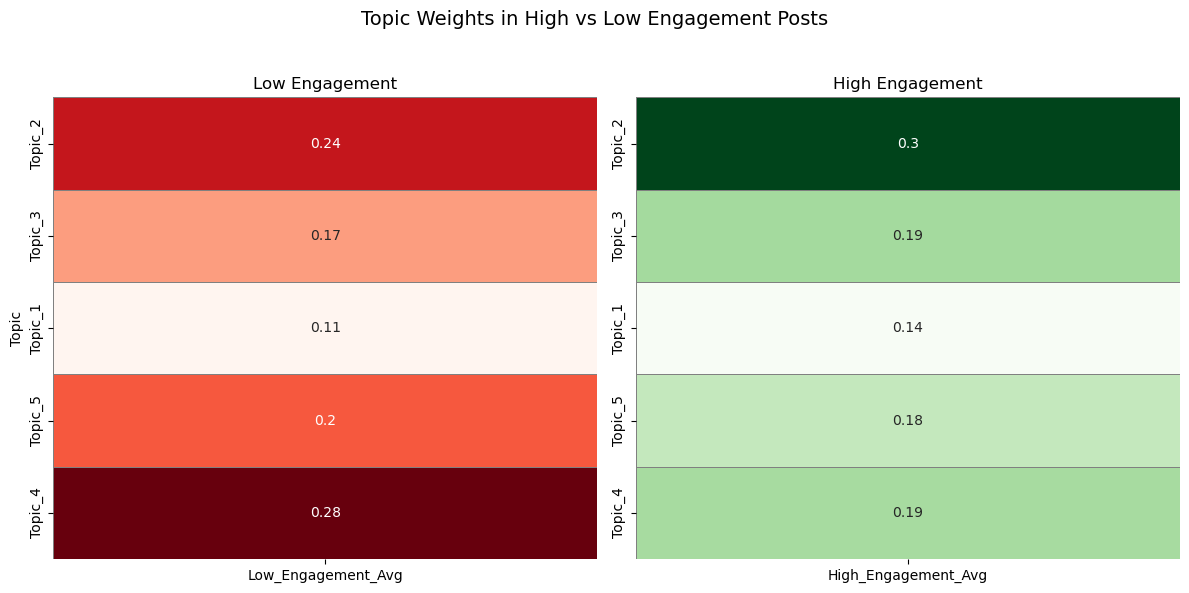

In [8]:
heatmap_df = comparison_table.set_index("Topic")[["Low_Engagement_Avg", "High_Engagement_Avg"]]

#create 1 row, 2 column subplot layout
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # <-- This creates axes[0] and axes[1]


#create the heatmap
sns.heatmap(
    heatmap_df[["Low_Engagement_Avg"]],
    annot=True,
    cmap="Reds",
    cbar=False,
    ax=axes[0],
    linecolor="gray",
    linewidths=0.5
)
axes[0].set_title("Low Engagement")
axes[0].set_xlabel("")

sns.heatmap(
    heatmap_df[["High_Engagement_Avg"]],
    annot=True,
    cmap="Greens",
    cbar=False,
    ax=axes[1],
    linecolor="gray",
    linewidths=0.5
)
axes[1].set_title("High Engagement")
axes[1].set_xlabel("")
axes[1].set_ylabel("")

#set title/layout
plt.suptitle("Topic Weights in High vs Low Engagement Posts", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # adjust to fit suptitle

#print plot
plt.show()

# Task D

Here are the major themes for the topics found through LDA.

Topic 1 = Savannah

Topic 2 = Mountain Animals

Topic 3 = Tundra

Topic 4 = Rock Formations

Topic 5 = Marine

# What advice would you give National Geographic if it wants to increase engagement on its Instagram page based on your findings in Tasks B and C?

After analyzing the captions and image labels of National Geographic’s Instagram posts, we found some clear patterns in what drives engagement. In Task B, we used logistic regression to predict post engagement based on text data. The model’s accuracy was strong given the limitations of non-video analysis using Google Vision. Captions and Vision accuracy results are nearly equal, however Google Vision TF-IDF matrix has 1195 descriptive terms, while Captions TF-IDF matrix had 3201 descriptive terms. Showing that Vision was able to accomplish similar predictive accuracy with less information.

After performing Task C, we found interesting findings. Certain visual themes showed up more often in high-performing posts. For example, Topic 1 — which we interpreted as “Mountain Animals” imagery — consistently appeared more in posts with higher engagement. These may include snouts, mountains, wildlife animals like cats with whiskers.
: 0.0099

In contrast, ToRock Formations— “Tundra” sc rocky & sandy landformsironments — was more common in posts with lower engagement. While still visually stunning, this kind of content may not connect as strongly with the average viewer or may feel less dynamic comparedlivelyve, warm, or emotionally rich
: 0.0068 visuals.

That being said, if NG wants to increase engagement on its Instagram, we'd highly encourage them tRock Formation away from "Tundrfocus on a" ting morehon the animals that reside in those mountains.nah" themed posts.